<a href="https://colab.research.google.com/github/sakshamkumar1/tensorflow-notebooks/blob/main/07_milestone_project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f9d42712-0c1a-3c95-51eb-384ffcc6de05)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-09 00:40:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-09 00:40:01 (78.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
import tensorflow_datasets as tfds

In [5]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [7]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

## Exploring the Food101 data from TensorFlow Datasets

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of the train data
train_one_sample = train_data.take(1)

In [11]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """
  )



  Image Shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 81
  Class name (str form): ramen
  


In [15]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

<Figure size 1000x1000 with 0 Axes>

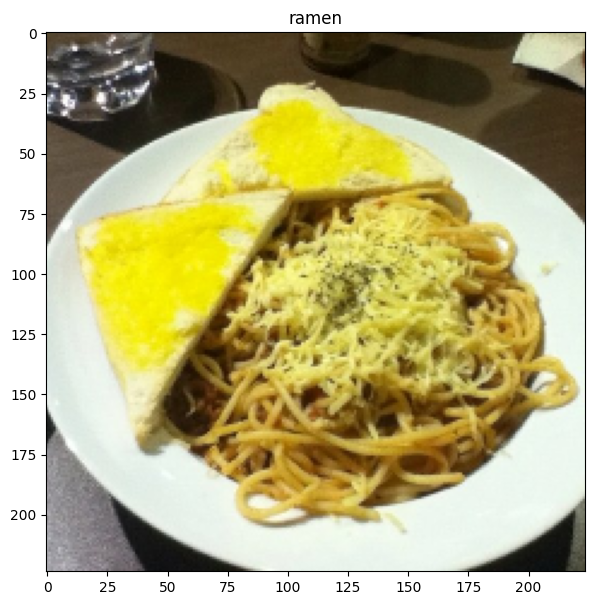

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  ax = plt.subplots(figsize=(10, 7))
  images = tf.image.resize(images, [224, 224])
  plt.imshow(images/255.)
  plt.title(class_names[label.numpy()])

## Create preprocessing functions for our data

In [36]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  # image = image/255. # not required for EfficientNet
  return tf.cast(image, tf.float32), label

In [37]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[242 254 252]
  [241 253 251]
  [240 252 250]
  ...
  [241 211 101]
  [242 212 102]
  [245 215 105]]

 [[240 252 250]
  [240 252 250]
  [239 251 249]
  ...
  [245 215 105]
  [242 212 102]
  [240 210 100]]]...,
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>

Image after preprocessing:
[[[240.4847  252.4847  250.4847 ]
  [238.42857 250.42857 248.42857]
  [238.29082 249.86224 248.07652]
  ...
  [251.4235  219.20923 107.78071]
  [246.3571  216.3571  106.3571 ]
  [241.92346 211.92346 101.92346]]

 [[237.07143 249.07143 247.07143]
  [238.      250.      248.     ]
  [240.14285 250.14285 249.14285]
  ...
  [248.22957 215.28569 101.85716]
  [250.99489 218.99489 106.27042]
  [243.07126 211.07126 100.07126]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>
